In [178]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

Using haar cascade

In [179]:
img = cv2.imread('./test_image/ryan_tedder1.jpg')
img.shape

(1334, 2000, 3)

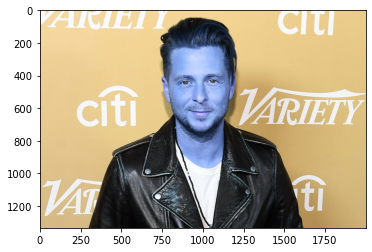

In [180]:
plt.imshow(img)

In [181]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(1334, 2000)

In [182]:
gray

array([[251, 251, 251, ..., 188, 188, 188],
       [251, 251, 251, ..., 188, 188, 188],
       [251, 251, 251, ..., 188, 188, 188],
       ...,
       [172, 172, 172, ..., 159, 159, 158],
       [172, 172, 172, ..., 159, 159, 158],
       [172, 172, 172, ..., 160, 159, 159]], dtype=uint8)

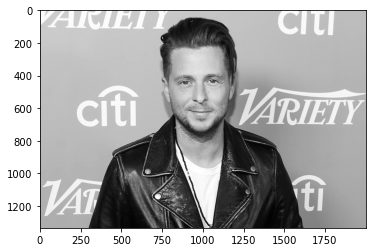

In [183]:
plt.imshow(gray, cmap = "gray")

###  HaarsCascade

In [185]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5) #??
faces # return an array of 4-values (x,y,w,h) (position of the face)

array([[746, 249, 468, 468]])

In [186]:
(x,y,w,h) = faces[0]
x,y,w,h

(746, 249, 468, 468)

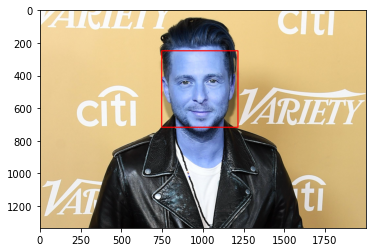

In [187]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),5)
plt.imshow(face_img)

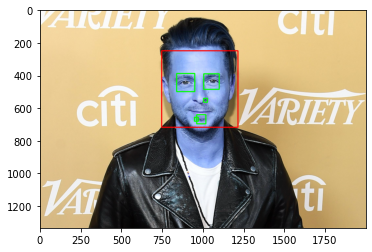

In [188]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),5)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

<h3 style='color:purple'>(2) Preprocessing: Crop the facial region of the image</h3>

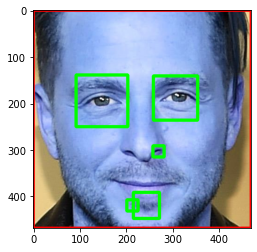

In [189]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

<h3 style='color:purple'>(3) Preprocessing: Load image, detect face. If eyes >=2, then save and crop the face region</h3>

In [190]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

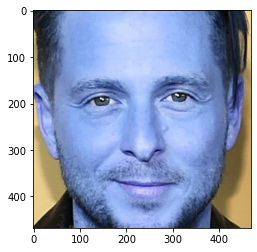

In [191]:
cropped_image = get_cropped_image_if_2_eyes("./test_image/ryan_tedder1.jpg")
plt.imshow(cropped_image)

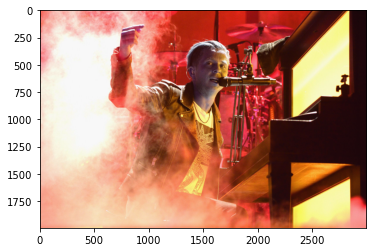

In [192]:
org_image_obstructed = cv2.imread("./test_image/ryan_tedder2.jpg")
plt.imshow(org_image_obstructed)

In [204]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes("./test_image/ryan_tedder2.jpg")
cropped_image_no_2_eyes

In [211]:
path_to_data = "./image_dataset/"
path_to_cropped_data = "./image_dataset/cropped/"

In [212]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)
img_dirs

['./image_dataset/adam_levine',
 './image_dataset/cropped',
 './image_dataset/katy_perry',
 './image_dataset/rihanna',
 './image_dataset/ryan_tedder']

In [213]:
import shutil
if os.path.exists(path_to_cropped_data):
     shutil.rmtree(path_to_cropped_data)
os.mkdir(path_to_cropped_data)

In [214]:
cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    for entry in os.scandir(img_dir):
        try:
            roi_color = get_cropped_image_if_2_eyes(entry.path)
        except:
            continue
        if roi_color is not None:
            cropped_folder_path = path_to_cropped_data + celebrity_name
            if not os.path.exists(cropped_folder_path):
                os.makedirs(cropped_folder_path)
                cropped_image_dirs.append(cropped_folder_path)
                print("Generating cropped images in folder: ",cropped_folder_path)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder_path + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

Generating cropped images in folder:  ./image_dataset/cropped/adam_levine
Generating cropped images in folder:  ./image_dataset/cropped/katy_perry
Generating cropped images in folder:  ./image_dataset/cropped/rihanna
Generating cropped images in folder:  ./image_dataset/cropped/ryan_tedder


### Wavelet transform

In [215]:
#import from stackoverflow
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

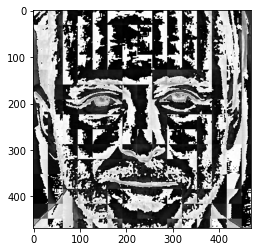

In [216]:
im_har = w2d(cropped_image,'db1',5)
plt.imshow(im_har, cmap='gray')

### Transfrorm & create X-Y training set

In [217]:
#1. Transform the image 
#2. Stack theoriginal &the transformed img vertically (celebrity_file_names_dict)
celebrity_file_names_dict

{'adam_levine': ['./image_dataset/cropped/adam_levine/adam_levine1.png',
  './image_dataset/cropped/adam_levine/adam_levine2.png',
  './image_dataset/cropped/adam_levine/adam_levine3.png',
  './image_dataset/cropped/adam_levine/adam_levine4.png',
  './image_dataset/cropped/adam_levine/adam_levine5.png',
  './image_dataset/cropped/adam_levine/adam_levine6.png',
  './image_dataset/cropped/adam_levine/adam_levine7.png',
  './image_dataset/cropped/adam_levine/adam_levine8.png',
  './image_dataset/cropped/adam_levine/adam_levine9.png',
  './image_dataset/cropped/adam_levine/adam_levine10.png',
  './image_dataset/cropped/adam_levine/adam_levine11.png',
  './image_dataset/cropped/adam_levine/adam_levine12.png',
  './image_dataset/cropped/adam_levine/adam_levine13.png',
  './image_dataset/cropped/adam_levine/adam_levine14.png',
  './image_dataset/cropped/adam_levine/adam_levine15.png',
  './image_dataset/cropped/adam_levine/adam_levine16.png',
  './image_dataset/cropped/adam_levine/adam_levine

In [218]:
cropped_image.shape

(468, 468, 3)

In [219]:
#after deleting unwanted cropped_img, re-create the celeb dict
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'adam_levine': ['./image_dataset/cropped/adam_levine\\adam_levine1.png',
  './image_dataset/cropped/adam_levine\\adam_levine10.png',
  './image_dataset/cropped/adam_levine\\adam_levine11.png',
  './image_dataset/cropped/adam_levine\\adam_levine12.png',
  './image_dataset/cropped/adam_levine\\adam_levine13.png',
  './image_dataset/cropped/adam_levine\\adam_levine15.png',
  './image_dataset/cropped/adam_levine\\adam_levine16.png',
  './image_dataset/cropped/adam_levine\\adam_levine18.png',
  './image_dataset/cropped/adam_levine\\adam_levine19.png',
  './image_dataset/cropped/adam_levine\\adam_levine2.png',
  './image_dataset/cropped/adam_levine\\adam_levine20.png',
  './image_dataset/cropped/adam_levine\\adam_levine22.png',
  './image_dataset/cropped/adam_levine\\adam_levine24.png',
  './image_dataset/cropped/adam_levine\\adam_levine25.png',
  './image_dataset/cropped/adam_levine\\adam_levine27.png',
  './image_dataset/cropped/adam_levine\\adam_levine28.png',
  './image_dataset/cropped/

In [220]:
#because y cannot be a name => tranform name to number
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'adam_levine': 0, 'katy_perry': 1, 'rihanna': 2, 'ryan_tedder': 3}

In [221]:
X, y = [], [] # y has to be some number (1, 2, 3, 4)
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scaled_raw_img = cv2.resize(img, (32, 32)) #need to have same size between X & Y (X => Y mapping)
        img_har = w2d(img,'db1',5)
        scaled_img_har = cv2.resize(img_har, (32, 32)) #need to have same size between X & Y (X => Y mapping)
        combined_img = np.vstack((scaled_raw_img.reshape(32*32*3,1),scaled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])     

In [222]:
len(X) # no of img in 4 folders

255

In [223]:
len(X[0]) # = 32*32*3 + 32*32*1

4096

In [224]:
X[0]# an array of pixel values (integer)(2D array)

array([[108],
       [150],
       [179],
       ...,
       [237],
       [238],
       [171]], dtype=uint8)

In [225]:
type(X), X

(list,
 [array([[108],
         [150],
         [179],
         ...,
         [237],
         [238],
         [171]], dtype=uint8),
  array([[ 20],
         [ 24],
         [ 25],
         ...,
         [ 47],
         [237],
         [ 94]], dtype=uint8),
  array([[ 17],
         [ 14],
         [ 36],
         ...,
         [240],
         [236],
         [ 20]], dtype=uint8),
  array([[ 44],
         [ 46],
         [ 27],
         ...,
         [196],
         [243],
         [218]], dtype=uint8),
  array([[ 27],
         [ 32],
         [ 33],
         ...,
         [ 10],
         [251],
         [244]], dtype=uint8),
  array([[ 24],
         [ 18],
         [ 34],
         ...,
         [244],
         [243],
         [241]], dtype=uint8),
  array([[34],
         [36],
         [46],
         ...,
         [11],
         [11],
         [11]], dtype=uint8),
  array([[237],
         [237],
         [237],
         ...,
         [  0],
         [  0],
         [  0]], dtype=uint8),

In [226]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape # convert to float, so that interactwith sklearn ezier (). Integer type still work but sklearn gives lots  of warning

(255, 4096)

In [227]:
X

array([[108., 150., 179., ..., 237., 238., 171.],
       [ 20.,  24.,  25., ...,  47., 237.,  94.],
       [ 17.,  14.,  36., ..., 240., 236.,  20.],
       ...,
       [  0.,   2.,   2., ..., 158., 138., 236.],
       [180., 140., 112., ...,  31.,  36., 246.],
       [ 25.,  27.,  38., ...,  79.,  36.,  16.]])

In [228]:
X[0]

array([108., 150., 179., ..., 237., 238., 171.])

### Model Training

We will use SVM with rbf kernel, tuned with heuristic finetuning


In [229]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [232]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
#create pipeline 1st because we want to scale our data 1st
#2nd step: create SVM model, get random parameter, finetune l8r
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))]) #tuning these para (empirical)
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.6875

In [234]:
len(X_test)

64

In [233]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.70      0.64      0.67        11
           1       0.64      0.56      0.60        16
           2       0.73      0.70      0.71        23
           3       0.67      0.86      0.75        14

    accuracy                           0.69        64
   macro avg       0.68      0.69      0.68        64
weighted avg       0.69      0.69      0.68        64



### Use GridSearch to try out different models with different parameters. Goal is to come up with best modle with best fine tuned parameters

In [175]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [249]:
#define different candidate models & compare
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10,20,40]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10,20,40]
        }
    }
}

In [250]:
# use GridSrearchCV to train the models
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model']) #scale the data first
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False) #cv = 5: 1sttime: train 1-80, last 20 test
    #2ndtime: 1-60 & 80-100 train, 60-80 test...keep going...then aver out the score
    #internally GridSerach split train =>tran & val test
    #clf = classifier
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

model  best_score  \
0                  svm    0.775304   
1        random_forest    0.638462   
2  logistic_regression    0.806748   

                                    best_params  
0        {'svc__C': 1, 'svc__kernel': 'linear'}  
1  {'randomforestclassifier__n_estimators': 40}  
2                 {'logisticregression__C': 20}

In [251]:
scores

[{'model': 'svm',
  'best_score': 0.7753036437246964,
  'best_params': {'svc__C': 1, 'svc__kernel': 'linear'}},
 {'model': 'random_forest',
  'best_score': 0.6384615384615384,
  'best_params': {'randomforestclassifier__n_estimators': 40}},
 {'model': 'logistic_regression',
  'best_score': 0.8067476383265857,
  'best_params': {'logisticregression__C': 20}}]

In [252]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=40))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=20, solver='liblinear'))])}

In [253]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.71875

In [254]:
best_estimators['svm'].score(X_test,y_test)

0.6875

In [255]:
best_estimators['random_forest'].score(X_test,y_test)

0.65625

In [256]:
best_clf = best_estimators['logistic_regression']

In [257]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[ 7,  1,  1,  2],
       [ 0,  9,  5,  2],
       [ 0,  4, 18,  1],
       [ 2,  0,  0, 12]], dtype=int64)

Text(69.0, 0.5, 'Truth')

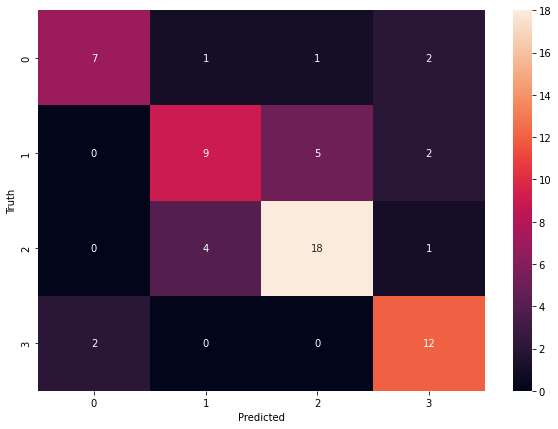

In [258]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [259]:
class_dict

{'adam_levine': 0, 'katy_perry': 1, 'rihanna': 2, 'ryan_tedder': 3}

### Save the trained model

In [260]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 
#the saved model is like a binary encrypted file

['saved_model.pkl']

### Save the class dictionary

In [261]:
# because these number will be useful when we write python flask server
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))